In [1]:
### Uncomment to run in Colab
# !pip install git+https://github.com/pnnl/DeepDataProfiler.git
# !pip install pytorchcv

## Deep Data Profiler and Spectral Analysis

The DeepDataProfiler methods featured in this tutorial are largely based on two papers (listed below) that borrow methods from Random Matrix Theory and statistical physics.

These methods act only on the weights of the Fully Connected and
Convolutional layers a deep neural network. Despite this, they have
proven effective in predicting
1. Test accuracies with no access to the data distribution on which it was trained OR tested 
2. Relative performance between models of similar architecture classes
3. Model and architecture improvements while training

See more at the bottom of this tutorial for references, as well as some details on our improvements over the original work.

**The core observation these metrics use, following results from Random Matrix Theory, is that the covariance of the weight matrices $X = W^TW$, of DNN layers start out looking like the left plot below. As these layers are trained by Stochastic Gradient Descent, the ESD (empirical spectral distribution) of $X$ systematically gain fat-tails, like the plot on the right (which is a layer that has been trained on ImageNet).** 

We can use this measure to know how much a layer (or entire model) has been trained, and how likely it is that a layer (or model) has been overfit. 

<table>
    <caption style="caption-side:bottom" display="table-caption" > Eigenvalue spectral distribution of weights of a a network with random initialization (left) and a trained network (right)</caption>
    <tr>
<td> <img src="https://github.com/pnnl/DeepDataProfiler/blob/master/tutorials/images/random_init_ESD.png?raw=1" alt="ESD of weights of a random initialization" style="width: 350px;"/> </td>
<td> <img src="https://github.com/pnnl/DeepDataProfiler/blob/master/tutorials/images/trained_ESD.png?raw=1" alt="ESD of weights of a trained network" style="width: 350px;"/> </td>
</tr></table>


In [2]:
# first, we import the DeepDataProfiler and PyTorch
import deep_data_profiler as ddp
import torch
import matplotlib.pyplot as plt
import pytorchcv

### First scenario

We are given two models. (Pretend) we have no knowledge of the data the models have been trained on, where they came from, etc. We just download the weights from the PyTorch website, and can compare their per layer and total performance.

In [3]:
import torchvision.models as tvmodels

model_random_init = tvmodels.resnet18(pretrained=False).eval()

model_trained = tvmodels.resnet18(pretrained=True).eval()

#### We can also examine the individual layers of the models to profile the extent of their training. 

As noted, we expect the spectral distribution of the trained models to show evidence of fat-tails. For the below example, we choose to plot the Empirical Spectral Distributions for the layers. 

We make per layer predictions (with the `.layer_RMT()` method) based on the fit of the power law coefficient $\alpha$, where very Heavy=Tailed distributions are mostly expected to be better trained. Per Martin and Mahoney, different fits fall under different Universality classes of Heavy-Tailed matrices. Namely, for $\mu =  2(\alpha - 1)$, we threshold on $0< \mu <4$ for good regularization and performance, $4\leq \mu <7$ for likely good performance but not as well regularized, and $\mu \geq7$ for poor regularization and poor test performance.

**First, for the randomly initialized model:**

In [4]:
# initialize ddp.SpectralAnalysis for the randomly initialized model
analysis_random_init = ddp.SpectralAnalysis(model_random_init)

# compute the SVD of X for each layer, return in dict
eigenvalue_dictionary_random = analysis_random_init.spectral_analysis()

# fit a power law distribution for each spectral distribution computed, per layer 
alpha_dictionary_random = analysis_random_init.fit_power_law(eig_dict=eigenvalue_dictionary_random)

# threshold on the "fat-tailedness" of the power-law distribution
layer_phenomenology_random = analysis_random_init.layer_RMT(alpha_dict=alpha_dictionary_random)

xmin progress: 71%

You can can plot the empirical spectral distribution for all of the layers by calling `analysis_random_init.layer_RMT(plot_eig=True)`. We make plots for a few representative layers. We first **compute the same metrics for the ImageNet trained model:**

In [5]:
# initialize ddp.SpectralAnalysis for the model trained on ImageNet
analysis_trained = ddp.SpectralAnalysis(model_trained)

# compute the SVD of X for each layer, return in dict
eigenvalue_dict_trained = analysis_trained.spectral_analysis()

# fit a power law distribution for each spectral distribution computed, per layer 
alpha_dict_trained = analysis_trained.fit_power_law(eig_dict=eigenvalue_dict_trained)

# threshold on the "fat-tailedness" of the power-law distribution
layer_phenomenology_trained = analysis_trained.layer_RMT(alpha_dict=alpha_dict_trained)

xmin progress: 78%

We plot a sample of the layers side-by-side below. Notice that (1) these plots qualitatively match the comparison of the plots above of the ESD of weights of a trained network and a network with random initialization and (2) the power law fit shows that the well-trained layers have fat-tails.

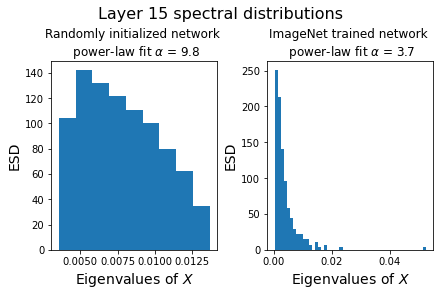

Randomly initialized network Layer 15 prediction: very likely not trained and not regularized.
ImageNet trained network Layer 15 prediction: somewhat well regularized and likely has good performance on a test set.


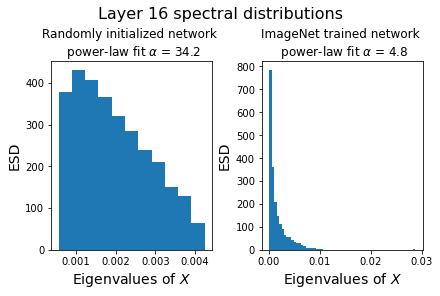

Randomly initialized network Layer 16 prediction: very likely not trained and not regularized.
ImageNet trained network Layer 16 prediction: very likely not trained and not regularized.


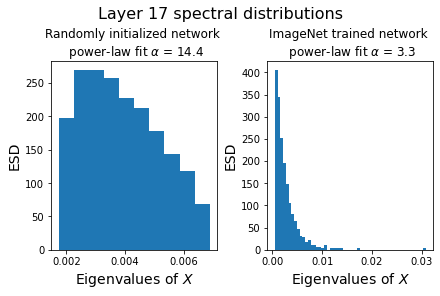

Randomly initialized network Layer 17 prediction: very likely not trained and not regularized.
ImageNet trained network Layer 17 prediction: somewhat well regularized and likely has good performance on a test set.


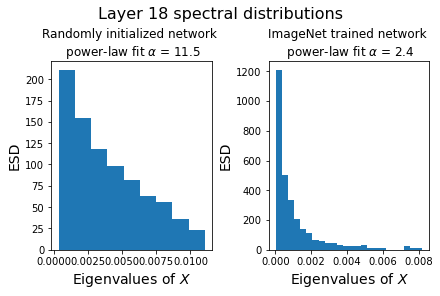

Randomly initialized network Layer 18 prediction: very likely not trained and not regularized.
ImageNet trained network Layer 18 prediction: regularized and good performance on a test set.


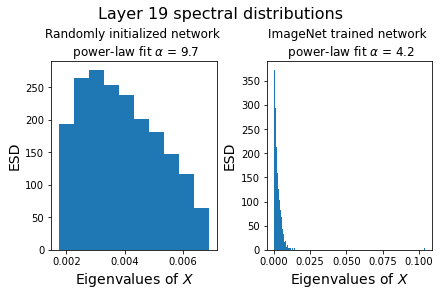

Randomly initialized network Layer 19 prediction: very likely not trained and not regularized.
ImageNet trained network Layer 19 prediction: somewhat well regularized and likely has good performance on a test set.


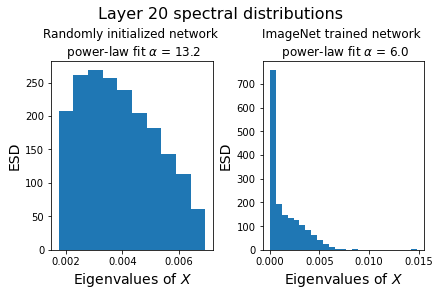

Randomly initialized network Layer 20 prediction: very likely not trained and not regularized.
ImageNet trained network Layer 20 prediction: very likely not trained and not regularized.


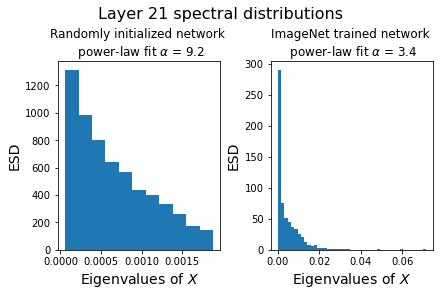

Randomly initialized network Layer 21 prediction: very likely not trained and not regularized.
ImageNet trained network Layer 21 prediction: somewhat well regularized and likely has good performance on a test set.


In [6]:
# iterate through the final layers, which the dicts use as keys
layers = list(alpha_dict_trained.items())[14:]
for idx, (layer, _) in enumerate(layers):
    
    # grab eigenvalues from the trained and random dicts
    eigenvalues_random, _ = eigenvalue_dictionary_random[layer]
    eigenvalues_trained, _ = eigenvalue_dict_trained[layer]
    
    # power law alphas
    alpha_random, _ = alpha_dictionary_random[layer]
    alpha_trained, _ = alpha_dict_trained[layer]
    
    # and get the per-layer regularization predictions
    phenom_random = layer_phenomenology_random[14+idx]
    phenom_trained = layer_phenomenology_trained[14+idx]
    
    
    fig, axs = plt.subplots(1, 2, constrained_layout=True)
    axs[0].hist(eigenvalues_random, bins="auto", density=True)
    axs[0].set_title("Randomly initialized network \n power-law fit" + fr" $\alpha$ = {round(alpha_random, 1)}")
    axs[0].set_xlabel('Eigenvalues of $X$', fontsize = 14)
    axs[0].set_ylabel('ESD', fontsize = 14)


    axs[1].hist(eigenvalues_trained, bins="auto", density=True)
    axs[1].set_title("ImageNet trained network \n power-law fit" + fr" $\alpha$ = {round(alpha_trained, 1)}")
    axs[1].set_xlabel('Eigenvalues of $X$', fontsize = 14)
    axs[1].set_ylabel('ESD', fontsize = 14)


    fig.suptitle(f"Layer {layer} spectral distributions", fontsize=16)
    
    plt.show()
    print(f"Randomly initialized network {phenom_random}")
    print(f"ImageNet trained network {phenom_trained}")


### "Universal" capacity metric
**We can also output a single metric that allows us to make a good prediction about the relative performance of the models.** 

Here, we use the Universal capacity metric, defined as $\hat{\alpha}=\frac{1}{L} \sum_{l} \alpha_{l} \log \lambda_{\max , l}$, where $L$ is the number of layers of the network and $l$ the specific layers, $\alpha_L$ is the power-law fit for the layer, and $\lambda_{\max , l}$ the largest eigenvalue for the covariance of the weights $X$. For more on this metric, see https://arxiv.org/abs/2002.06716.

In [7]:
# with a single metric, we can know the better trained model
metric_trained = analysis_trained.universal_metric()
metric_random = analysis_random_init.universal_metric()

print(f"The trained model's metric: {round(metric_trained, 2)} (significantly larger, indicative of training)")
print(f"The randomly initialized model's metric: {round(metric_random, 2)} (smaller, i.e. less-regularized)")


xmin progress: 44%

xmin progress: 76%

xmin progress: 55%

The trained model's metric: -13.68 (significantly larger, indicative of training)
The randomly initialized model's metric: -57.37 (smaller, i.e. less-regularized)


### Second scenario, eigenvalue spectral distribution during training


In this scenario, we track a small model as it trains with the metric. 

In [8]:
# define a small model to be trained on CIFAR-10
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Net().to(device)


Uncomment and run the lines below if you want to actually train the small model above on CIFAR-10 and track the SpectralAnalysis metric as it trains. The training loop takes roughly 3 minutes to run on a Tesla P100 GPU in Colab and 30 minutes to run on our CPU.

If running in Colab, you should either run the training loop below or manually download the weights. Otherwise, you can also use our already trained weights provided in our repo in the cell below (after the training loop).

Files already downloaded and verified
Files already downloaded and verified


[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[1,  3125] loss: 6405.206


[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[1,  2500] loss: 4315.010


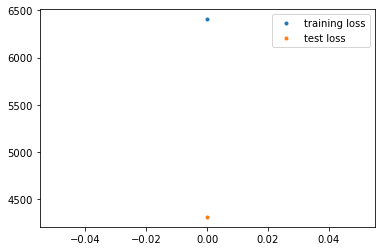

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[2,  3125] loss: 4986.226


[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[2,  2500] loss: 3709.480


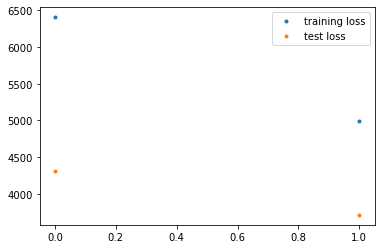

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[3,  3125] loss: 4389.834


[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[3,  2500] loss: 3286.331


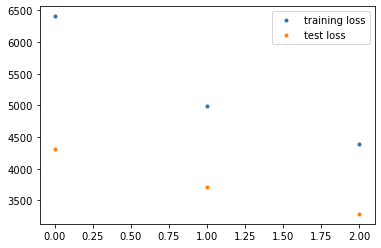

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[4,  3125] loss: 3999.247


[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[4,  2500] loss: 3048.034


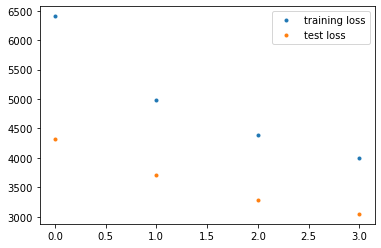

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[5,  3125] loss: 3725.759


[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[5,  2500] loss: 3072.383


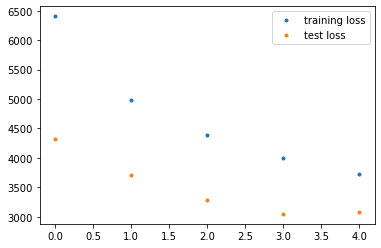

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[6,  3125] loss: 3507.358


[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[6,  2500] loss: 2918.234


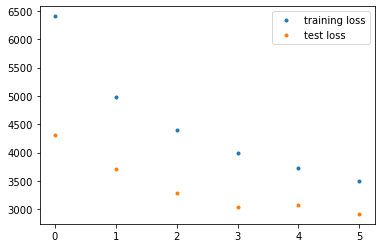

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[7,  3125] loss: 3329.663


[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[7,  2500] loss: 2838.520


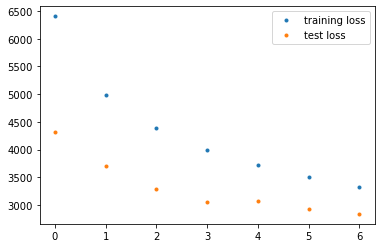

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[8,  3125] loss: 3186.989


[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[8,  2500] loss: 2701.962


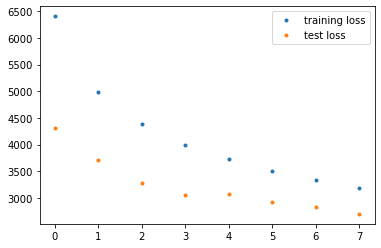

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[9,  3125] loss: 3061.155


[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[9,  2500] loss: 2784.690


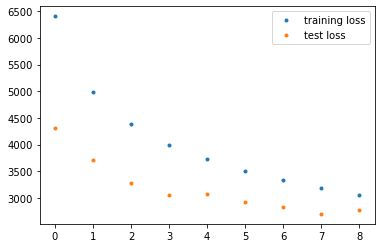

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[10,  3125] loss: 2937.584


[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[10,  2500] loss: 2606.141


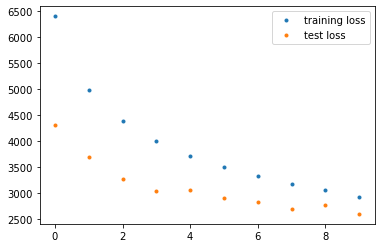

In [9]:
import torchvision
from torchvision import transforms
from pathlib import Path
import torch.optim as optim


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# make path if it does not already exist
Path("spectral_data/cifar_files/").mkdir(parents=True, exist_ok=True)

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

per_epoch_loss = []
test_loss = []
test_error = []
training_error = []

for epoch in range(10):
    running_loss = 0.0
    net.train()
    train_acc_total = 0.0
    for i, data in enumerate(trainloader):
        inputs, labels = data
        optimizer.zero_grad()

        outputs = net(inputs.to(device))
        train_outputs = torch.argmax(outputs, dim=1).to(device)
        train_acc_total += (train_outputs == labels.to(device)).sum() 

        loss = criterion(outputs.to(device), labels.to(device))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # print every epoch
    training_error.append(1 - (train_acc_total / len(trainset)).item())
    per_epoch_loss.append(running_loss)
    print('[%d, %5d] loss: %.3f' %
        (epoch + 1, i + 1, running_loss))


    running_test_loss = 0.0
    net.eval()
    test_acc_total = 0

    for i, data in enumerate(testloader):
        inputs, labels = data

       # forward + backward + optimize
        outputs = net(inputs.to(device))
        test_outputs = torch.argmax(outputs, dim=1).to(device)
        test_acc_total += (test_outputs == labels.to(device)).sum() 

        loss = criterion(outputs.to(device), labels.to(device))

       # print statistics
        running_test_loss += loss.item()

    # print every epoch
    test_error.append(1. - (test_acc_total / len(testset)).item())
    test_loss.append(running_test_loss)
    print('[%d, %5d] loss: %.3f' %
        (epoch + 1, i + 1, running_test_loss))
    running_test_loss = 0.0

    PATH = f'spectral_data/cifar_files/cifar_net_{epoch}.pth'
    torch.save(net.state_dict(), PATH)
  
    plt.plot(per_epoch_loss, '.', label="training loss")
    plt.plot(test_loss, '.', label="test loss")
    plt.legend()

    plt.show()



#### Here, we use our already trained weights to check how well our model tracks performance.

We plot the ESD for an arbitrarily chosen layer at each training step, and give it's power-law fit. **Note** that the power law $\alpha_L$ fit for the distribution tends to decrease during the training as the ESDs gain fatter tails.

In [10]:
# define (if not pulled above) the precent train error and test error from the training epochs
training_error = [0.56, 0.5, 0.46, 0.43, 0.41, 0.39, 0.37, 0.36, 0.34, 0.32]
test_error = [0.53, 0.48, 0.46, 0.43, 0.42, 0.4, 0.39, 0.39, 0.38, 0.38]


xmin progress: 61%

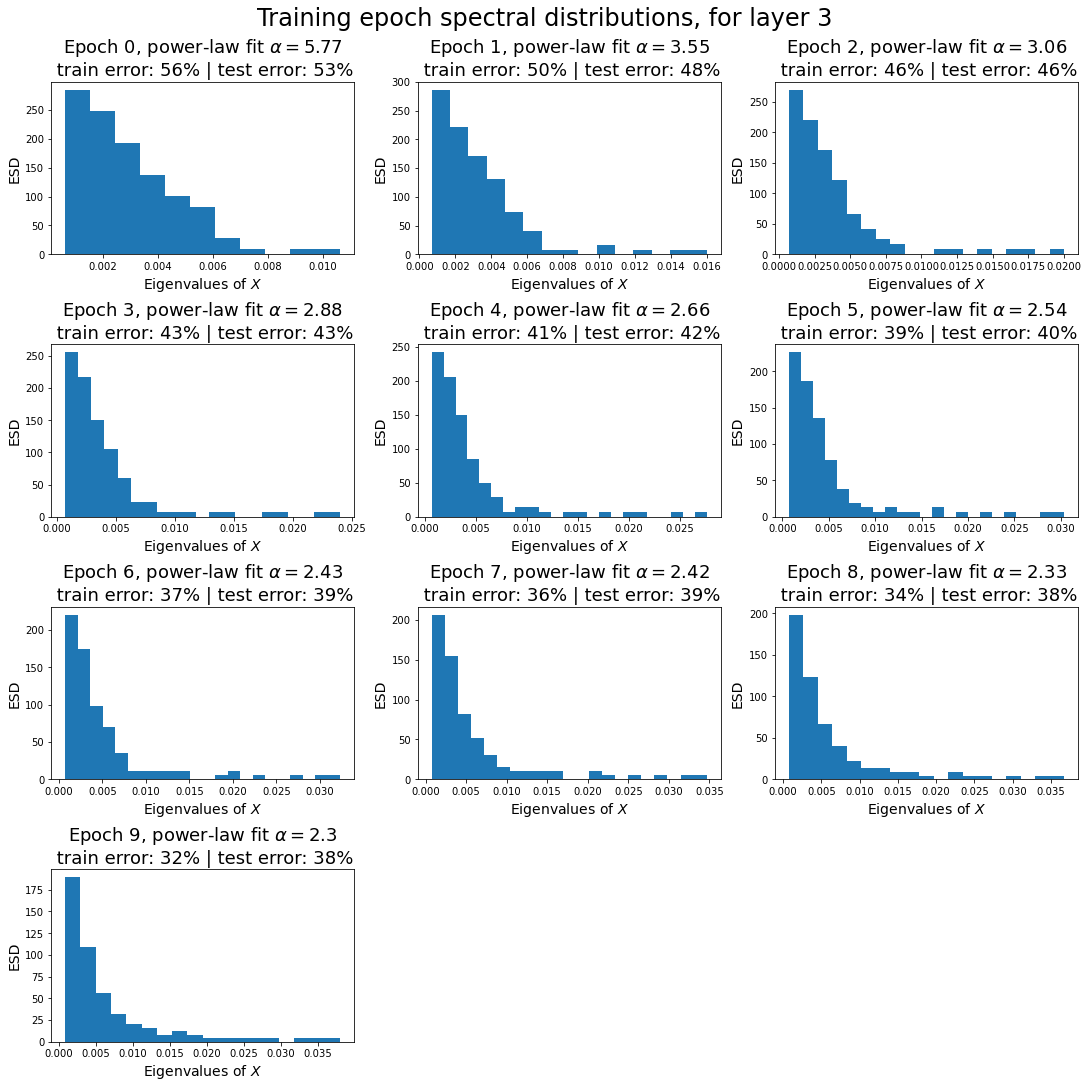

In [11]:
universal_metrics = []    
layer_to_observe = 3

fig, axs = plt.subplots(4, 3, constrained_layout=True, figsize=(15, 15))

for i in range(10):
    PATH = f'spectral_data/cifar_files/cifar_net_{i}.pth'
    net.load_state_dict(torch.load(PATH, map_location=torch.device('cpu') ))
    
    # define SpectralAnalysis, and calculate the model metric
    analysis = ddp.SpectralAnalysis(net)
    # compute the SVD of X for each layer, return in dict
    eigenvalue_dict = analysis.spectral_analysis()
    # fit a power law distribution for each spectral distribution computed, per layer 
    alpha_dict = analysis.fit_power_law(eig_dict=eigenvalue_dict)
    
    # choose an arbitrary layer to plot 
    eigenvalues, _ = eigenvalue_dict[layer_to_observe]
    alpha, _ = alpha_dict[layer_to_observe]
    axs[i//3, i%3].hist(eigenvalues, bins="auto", density=True)
    axs[i//3, i%3].set_title(
        (fr"Epoch {i}, power-law fit $\alpha = {round(alpha, 2)}$" 
         + f"\n train error: {int(training_error[i]*100)}% | test error: {int(test_error[i]*100)}%"
                             ), fontsize=18)
    axs[i//3, i%3].set_xlabel('Eigenvalues of $X$', fontsize = 14)
    axs[i//3, i%3].set_ylabel('ESD', fontsize = 14)

    # collect the universal alpha metrics, per epoch
    universal_metrics.append(analysis.universal_metric(alpha_dict=alpha_dict))

fig.suptitle(f"Training epoch spectral distributions, for layer {layer_to_observe}", fontsize=24)
axs[-1, -1].axis('off')  
axs[-1, -2].axis('off')  
plt.show()

**We plot the per epoch training results below** (note the different y-axes on the plots below).

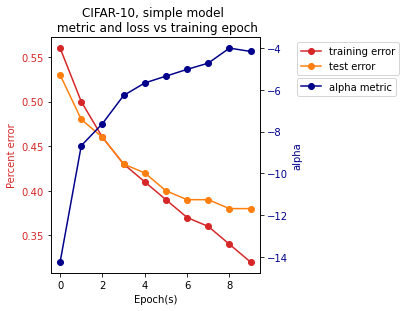

In [12]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('Epoch(s)')
ax1.set_ylabel('Percent error', color='tab:red')
ax1.plot(training_error, '-o', color='tab:red', label="training error")
ax1.plot(test_error,'-o', color='tab:orange', label="test error")

ax1.tick_params(axis='y', labelcolor='tab:red')
plt.legend(bbox_to_anchor=(1.15, 1), loc='upper left')


ax2 = ax1.twinx()  

color = 'darkblue'
ax2.set_ylabel('alpha', color=color)  # we already handled the x-label with ax1
ax2.plot(universal_metrics, '-o', color=color, label="alpha metric")
ax2.tick_params(axis='y', labelcolor=color)

plt.legend(bbox_to_anchor=(1.15, 0.85), loc='upper left')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("CIFAR-10, simple model \n metric and loss vs training epoch")
plt.show()

### Third scenario

In this final scenario, we use the set of metrics to perform a mock architecture search for a family of models and a dataset. We have evidence that the Universal capacity metric, presented during training above, serves as a useful metric for the generalizability of a model and its performance on a test dataset. For example, we see that the metric tracks test error on ImageNet very well for the VGG architecture family of models. 

*We note that this metric may be particularly instructive when performing small architecture tweaks, e.g. when deciding whether or not to add batch normalization to an existing architecture*

<img src="https://github.com/pnnl/DeepDataProfiler/blob/master/tutorials/images/vgg_metrics.png?raw=1" width="300" height="300" />


In our scenario, instead of ImageNet, we consider the dataset [Caltech-UCSD Birds 200](http://www.vision.caltech.edu/visipedia/CUB-200.html) ("CUB"). We have some initial models trained on the CUB dataset (example images below). 

However, we do not have access to the test set. **Despite this, we need to choose a model that generalizes well to deploy on the dataset.** 
![CUB example images](images/collage_cub.jpeg "Title")

In this scenario, we will be considering ResNets with different numbers of hidden layers trained on [Caltech-UCSD Birds 200](http://www.vision.caltech.edu/visipedia/CUB-200.html). 

While this scenario considers the number of hidden layers, this same approach works for other architecture decisions: e.g. whether to add dropout, a batch normalization layer, or even whether to try a different loss function.

We use a repository with models that have already been trained on the data. **Run the rest of the commented out cell below to download this repo with pip and grab the metric for these models. If you do not want to pull these models, we define the calculated metric below.**

In [13]:
cub_names = ['seresnet14_cub', 
             'seresnet16_cub', 
             'seresnet18_cub', 
             'seresnet26_cub']

In [14]:
# !pip install pytorchcv

# from pytorchcv.model_provider import get_model as ptcv_get_model

# metrics = []
# for model_name in cub_names:
#     # define model
#     model = ptcv_get_model(model_name, pretrained=True).eval()
#     # define the profiler
#     analysis = ddp.SpectralAnalysis(model)
#     metric = analysis.universal_metric()
#     metrics.append(metric)

# metrics

In [15]:
# manually define the metrics (if not pulled above) and the error percent
metrics = [-12.173933555293633,
           -15.870960965201313,
           -19.916924903954175,
           -28.505283826228215]

error_percent = [24.16, 23.32, 23.52, 22.99]

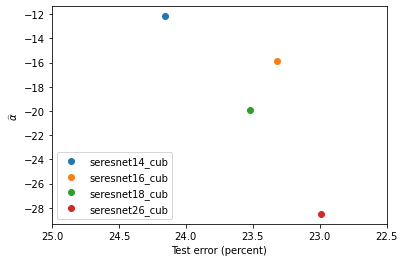

In [16]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()

for idx, model_str in enumerate(cub_names):
    ax.plot(error_percent[idx], metrics[idx], 'o', label=model_str)
    
ax.set_xlim(25, 22.5)  # decreasing time
plt.xlabel("Test error (percent)")
plt.ylabel(r"$\widehat{\alpha}$")
plt.legend(loc="lower left")
plt.show()

So, this plot supports that our metric also tracks test accuracy well for a variety of architectures on a completely different classification task than ImageNet.

### References and implementation details
The major improvement we make over the work mentioned above is our handling of convolutional layers: our approach at looking at the covariance of convolutional layers is both more principled and over an order of magnitude faster than [the code](https://github.com/CalculatedContent/WeightWatcher) released by the authors.


Papers:

[*Traditional and Heavy-Tailed Self Regularization in Neural Network Models*](https://arxiv.org/abs/1901.08276) by Martin and Mahoney 

[*Predicting trends in the quality of state-of-the-art neural networks without access to training or testing data*](https://arxiv.org/abs/2002.06716) by Martin, Peng, and Mahoney.
